In [ ]:
import torch
from torchvision import transforms
import cv2
from PIL import Image
from torch.utils.data import DataLoader , Dataset
import torch.nn as nn
import os
import glob
from torchvision import models

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np


In [ ]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [ ]:
path = os.getcwd()
for i in ["zero","one","two","three","four","five","six","seven","eight","nine"]:
  os.makedirs(path+"/파이토치/{}".format(i))

In [ ]:
for i in ["zero","one","two","three","four","five","six","seven","eight","nine"]:
  for j in ["train","test"]:
    os.makedirs(path+"/파이토치/{}/{}".format(i,j))
  

In [ ]:
def make_file(train):
  
  if train == True:

    for col,idx in zip(mnist_train.data,mnist_train.targets):
      col = np.array(col)
      mnist_label =  ["zero","one","two","three","four","five","six","seven","eight","nine"]
      index = mnist_label[idx]
      os.chdir(path+"/파이토치/{}/train".format(index))
      length = len(os.listdir(os.getcwd()))
      cv2.imwrite("{}_{}.jpg".format(index,length+1),col)
  
  elif train == False :

    for col,idx in zip(mnist_test.data,mnist_test.targets):
      col = np.array(col)
      mnist_label =  ["zero","one","two","three","four","five","six","seven","eight","nine"]
      index = mnist_label[idx]
      os.chdir(path+"/파이토치/{}/test".format(index))
      length = len(os.listdir(os.getcwd()))
      cv2.imwrite("{}_{}.jpg".format(index,length+1),col)
  



In [ ]:
make_file(train=True)

In [ ]:
make_file(train=False)

In [ ]:
label_list = ["zero","one","two","three","four","five","six","seven","eight","nine"]

In [ ]:
def file_list(train):
  trainset= []
  for i in ["zero","one","two","three","four","five","six","seven","eight","nine"]:
    file_list = glob.glob(path+"/파이토치/{}/{}".format(i,train)+"/*.jpg")
    trainset += file_list

  return trainset

train_file_list = file_list("train")
test_file_list = file_list("test")

class Custom_Dataset(Dataset):

  def __init__(self,file_list,transforms,label_list):
    self.file_list = file_list
    self.label_list = label_list
    self.transforms = transforms


  def __len__(self):
    return len(self.file_list)

  def __getitem__(self,index):
    img_path = self.file_list[index]
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    img = Image.fromarray(img)
    img_transformed = self.transforms(img)
    label_idx = img_path.split("/")[3]
    label = self.label_list.index(label_idx)

    return img_transformed, label


In [ ]:
img_path = cv2.imread(train_file_list[0])
img_path.shape

(28, 28, 3)

In [ ]:
transforms(Image.fromarray(img_path)).size()

torch.Size([3, 28, 28])

In [ ]:
transforms = transforms.Compose([
                                 transforms.ToTensor()
])

In [ ]:
train_tensor = Custom_Dataset(train_file_list,transforms,label_list)
test_tensor = Custom_Dataset(test_file_list,transforms,label_list)

In [ ]:
train_loader =  DataLoader(train_tensor,shuffle=True,batch_size=128,drop_last=True)
test_loader = DataLoader(test_tensor,shuffle=False,batch_size=128)


In [ ]:
for data,targets in train_loader:
  break

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
    )

    self.fc1 = nn.Linear(128,256)
    nn.init.xavier_uniform_(self.fc1.weight)
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    self.layer4 = nn.Sequential(
        self.fc1,
        nn.ReLU(),
        nn.Dropout(0.2)
    )

    self.fc2 = nn.Linear(256,10)
    nn.init.xavier_uniform_(self.fc2.weight)

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.avg_pool(out)
    out = out.squeeze()
    out = self.layer4(out)
    out = self.fc2(out)
    return out


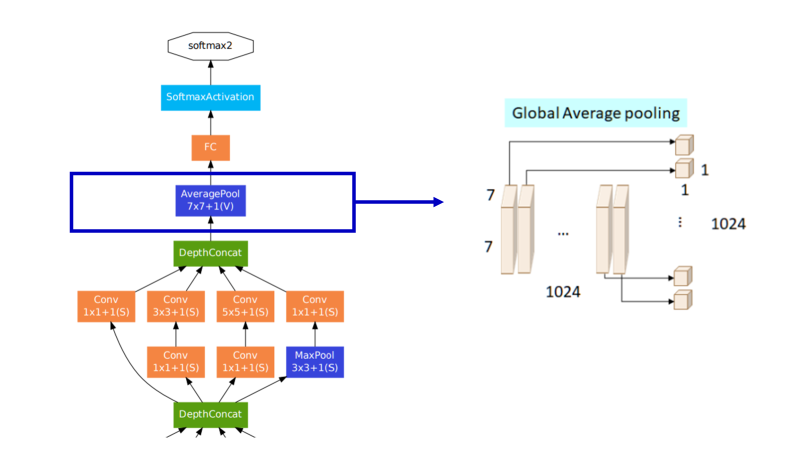

In [ ]:
img = cv2.imread("/content/drive/MyDrive/global_average_pooling.png")
Image.fromarray(img)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
batch_length = len(train_loader)
loss = []
for epoch in range(30):
  
  avg_loss = 0
  
  for data,targets in train_loader:
    
    data = data.to(device)
    targets = targets.to(device)
    hypothesis = model(data)
    cost = criterion(hypothesis,targets)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_loss += cost / batch_length
  loss.append(avg_loss)
  print("Epoch : {} loss 값 : {}".format(epoch+1,avg_loss))





Epoch : 1 loss 값 : 0.2814636826515198
Epoch : 2 loss 값 : 0.0678260549902916
Epoch : 3 loss 값 : 0.05072934180498123
Epoch : 4 loss 값 : 0.04120302200317383
Epoch : 5 loss 값 : 0.033782146871089935
Epoch : 6 loss 값 : 0.03292060270905495
Epoch : 7 loss 값 : 0.027695782482624054
Epoch : 8 loss 값 : 0.02582968771457672
Epoch : 9 loss 값 : 0.02354619838297367
Epoch : 10 loss 값 : 0.02159469947218895
Epoch : 11 loss 값 : 0.019065262749791145
Epoch : 12 loss 값 : 0.020228367298841476
Epoch : 13 loss 값 : 0.01892700605094433
Epoch : 14 loss 값 : 0.016135791316628456
Epoch : 15 loss 값 : 0.015151571482419968
Epoch : 16 loss 값 : 0.015562807209789753
Epoch : 17 loss 값 : 0.014450511895120144
Epoch : 18 loss 값 : 0.012093186378479004
Epoch : 19 loss 값 : 0.012482273392379284
Epoch : 20 loss 값 : 0.01389378122985363
Epoch : 21 loss 값 : 0.011688017286360264
Epoch : 22 loss 값 : 0.012596418149769306
Epoch : 23 loss 값 : 0.010952240787446499
Epoch : 24 loss 값 : 0.013879094272851944
Epoch : 25 loss 값 : 0.009028836153447

In [ ]:
def test():
  correct = 0
  model.eval()
  with torch.no_grad():
    for data,targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      outputs = model(data)
      _,predicted = torch.max(outputs,1)
      correct += predicted.eq(targets.data.view_as(predicted)).sum()
  length = len(test_loader.dataset)
  print("test데이터에서 정확도 : {}/{} {:.2f}%".format(correct,length,correct / length * 100))



In [ ]:
def train():
  correct = 0
  model.eval()
  with torch.no_grad():
    for data,targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      outputs = model(data)
      _,predicted = torch.max(outputs,1)
      correct += predicted.eq(targets.data.view_as(predicted)).sum()
  length = len(train_loader.dataset)
  print("train데이터에서 정확도 : {}/{} {:.2f}%".format(correct,length,correct / length * 100))


In [ ]:
train()

train데이터에서 정확도 : 59839/60000 99.73%


In [ ]:
test()

test데이터에서 정확도 : 9919/10000 99.19%


# 인셉션 모듈 추가

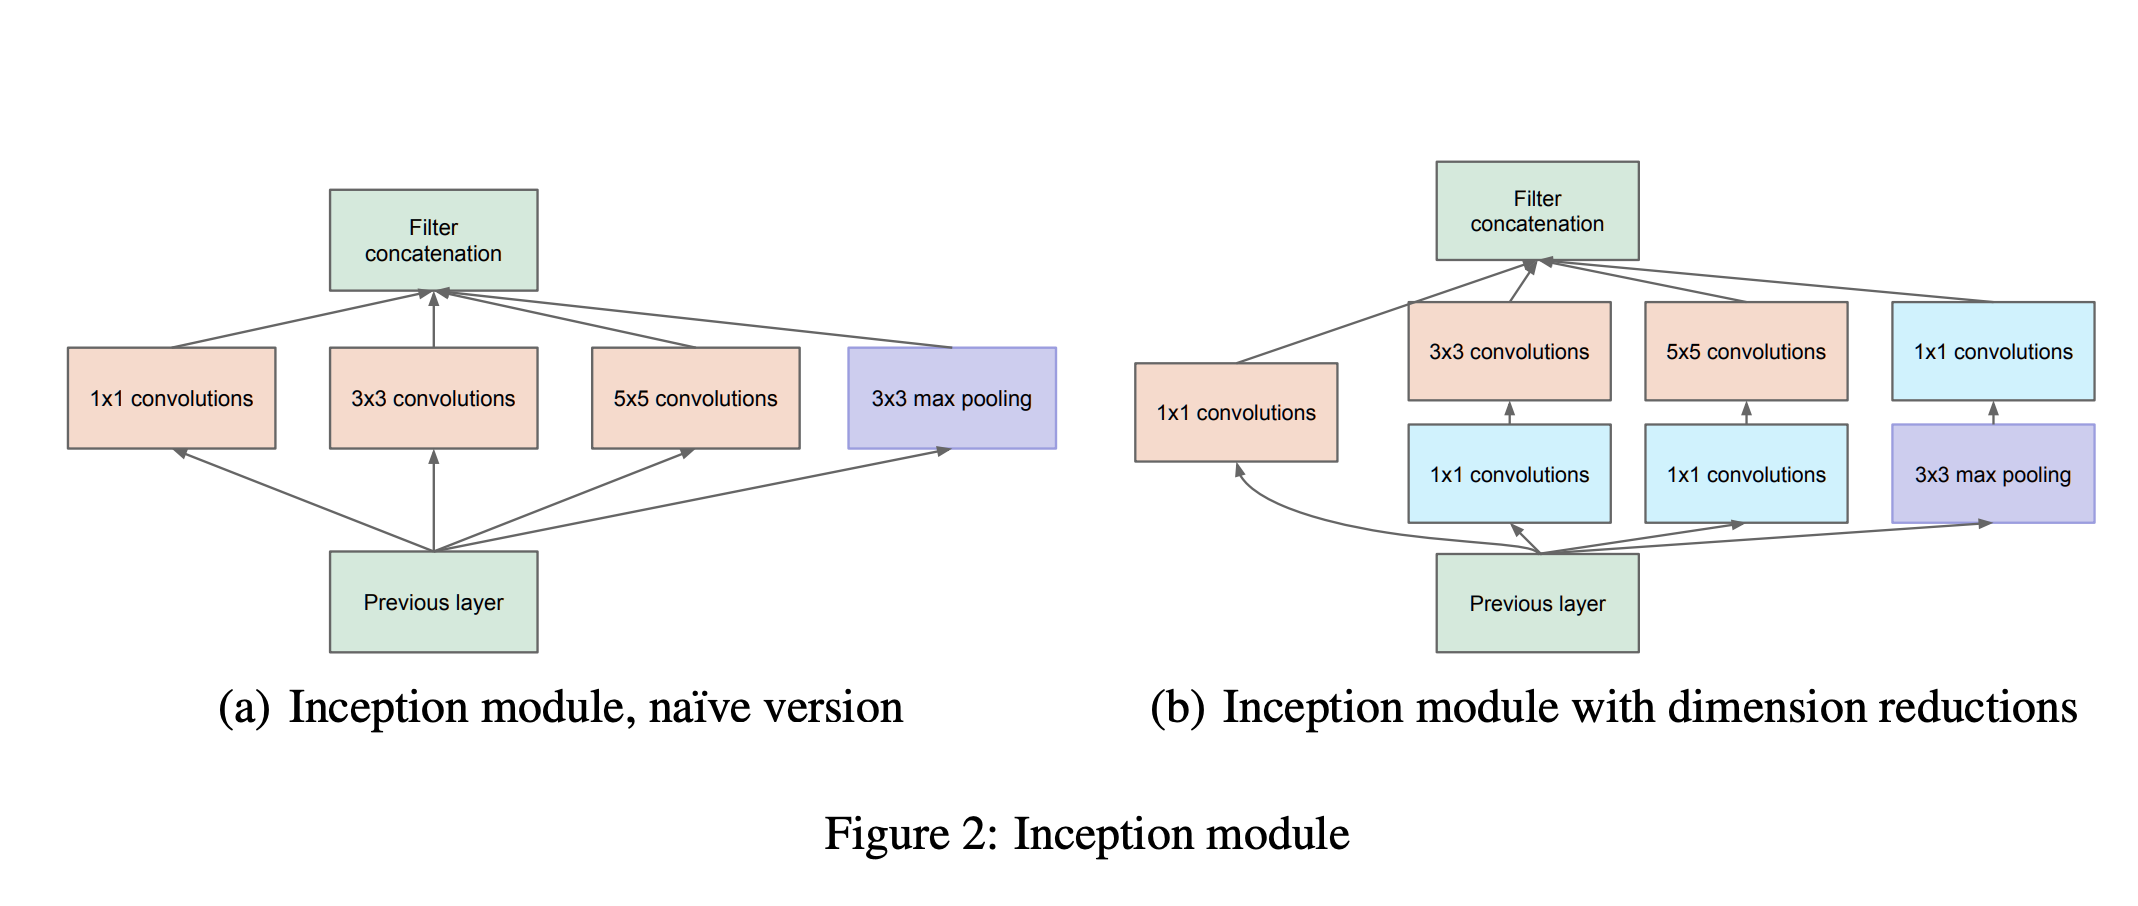

In [ ]:
img = cv2.imread("/content/drive/MyDrive/inception_module.png")
Image.fromarray(img)

In [ ]:
def conv_1(input_dim,output_dim):
  model = nn.Sequential(
      nn.Conv2d(input_dim,output_dim,1,1),
      nn.ReLU(),
  )
  return model

def conv_1_3(input_dim,mid_dim,output_dim):
  model = nn.Sequential(
      nn.Conv2d(input_dim,mid_dim,1,1),
      nn.ReLU(),
      nn.Conv2d(mid_dim,output_dim,kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
  )
  return model

def conv_1_5(input_dim,mid_dim,output_dim):
  model = nn.Sequential(
          nn.Conv2d(input_dim,mid_dim,1,1),
          nn.ReLU(),
          nn.Conv2d(mid_dim,output_dim,5,1,2),
          nn.ReLU()
      )
  return model

def max_3_1(input_dim,output_dim):
  model = nn.Sequential(
      nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
      nn.Conv2d(input_dim,output_dim,1,1),
      nn.ReLU(),
  )
  return model

class inception_module(nn.Module):
  def __init__(self,input_dim,output_dim_1,mid_dim_3,output_dim_3,mid_dim_5,output_dim_5,pool_dim):
    super().__init__()

    self.conv_1 = conv_1(input_dim,output_dim_1)

    self.conv_1_3 = conv_1_3(input_dim,mid_dim_3,output_dim_3)

    self.conv_1_5 = conv_1_5(input_dim,mid_dim_5,output_dim_5)

    self.max_3_1 = max_3_1(input_dim,pool_dim)

  def forward(self,x):
    out_1 = self.conv_1(x)
    out_2 = self.conv_1_3(x)
    out_3 = self.conv_1_5(x)
    out_4 = self.max_3_1(x)

    output = torch.cat([out_1,out_2,out_3,out_4],1)
    return output
  
class Cnn_Inception(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )

    self.layer2 = nn.Sequential(
        inception_module(64,128,96,128,16,32,32),
        inception_module(320,128,128,192,32,96,64),
        nn.MaxPool2d(3,2,1),
        nn.AdaptiveAvgPool2d(output_size=(1,1))
    )

    self.layer3 = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(480,10),
    )

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.squeeze()
    out = self.layer3(out)
    return out

In [ ]:
model_inception = Cnn_Inception().to(device)
optimizer = torch.optim.Adam(model_inception.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
batch_length = len(train_loader)
loss_inception = []
for epoch in range(10):
  
  avg_loss = 0
  
  for data,targets in train_loader:
    
    data = data.to(device)
    targets = targets.to(device)
    hypothesis = model_inception(data)
    cost = criterion(hypothesis,targets)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_loss += cost / batch_length
  loss_inception.append(avg_loss)
  print("Epoch : {} loss 값 : {}".format(epoch+1,avg_loss))

Epoch : 1 loss 값 : 0.41428127884864807
Epoch : 2 loss 값 : 0.09255471080541611
Epoch : 3 loss 값 : 0.07173003256320953
Epoch : 4 loss 값 : 0.061040688306093216
Epoch : 5 loss 값 : 0.05886248126626015
Epoch : 6 loss 값 : 0.05669708177447319
Epoch : 7 loss 값 : 0.05552823841571808
Epoch : 8 loss 값 : 0.05007799342274666
Epoch : 9 loss 값 : 0.04928164556622505
Epoch : 10 loss 값 : 0.04717203229665756


In [ ]:
def test():
  correct = 0
  model.eval()
  with torch.no_grad():
    for data,targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      outputs = model_inception(data)
      _,predicted = torch.max(outputs,1)
      correct += predicted.eq(targets.data.view_as(predicted)).sum()
  length = len(test_loader.dataset)
  print("test데이터에서 정확도 : {}/{} {:.2f}%".format(correct,length,correct / length * 100))

In [ ]:
def train():
  correct = 0
  model.eval()
  with torch.no_grad():
    for data,targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      outputs = model_inception(data)
      _,predicted = torch.max(outputs,1)
      correct += predicted.eq(targets.data.view_as(predicted)).sum()
  length = len(train_loader.dataset)
  print("train데이터에서 정확도 : {}/{} {:.2f}%".format(correct,length,correct / length * 100))


In [ ]:
train()

train데이터에서 정확도 : 59060/60000 98.43%


In [ ]:
test()

test데이터에서 정확도 : 9453/10000 94.53%


# 전이학습 및 파인튜닝

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)
optimizer = torch.optim.Adam(model_resnet18.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model_resnet18.fc = nn.Linear(in_features=512,out_features=10,bias=True)
model_resnet18.conv1 = nn.Conv2d(1,64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
model_resnet18 = model_resnet18.to(device)
print(model_resnet18)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
batch_length = len(train_loader)
loss_resnet18 = []
for epoch in range(10):
  
  avg_loss = 0
  
  for data,targets in train_loader:
    
    data = data.to(device)
    targets = targets.to(device)
    hypothesis = model_resnet18(data)
    cost = criterion(hypothesis,targets)
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_loss += cost / batch_length
  loss_resnet18.append(avg_loss)
  print("Epoch : {} loss 값 : {}".format(epoch+1,avg_loss))

Epoch : 1 loss 값 : 0.33028826117515564
Epoch : 2 loss 값 : 0.07730122655630112
Epoch : 3 loss 값 : 0.05931112542748451
Epoch : 4 loss 값 : 0.05130545049905777
Epoch : 5 loss 값 : 0.04245994985103607
Epoch : 6 loss 값 : 0.03595559298992157
Epoch : 7 loss 값 : 0.03050476498901844
Epoch : 8 loss 값 : 0.028751827776432037
Epoch : 9 loss 값 : 0.02474466897547245
Epoch : 10 loss 값 : 0.022319277748465538


In [ ]:
def test():
  correct = 0
  model.eval()
  with torch.no_grad():
    for data,targets in test_loader:
      data = data.to(device)
      targets = targets.to(device)
      outputs = model_resnet18(data)
      _,predicted = torch.max(outputs,1)
      correct += predicted.eq(targets.data.view_as(predicted)).sum()
  length = len(test_loader.dataset)
  print("test데이터에서 정확도 : {}/{} {:.2f}%".format(correct,length,correct / length * 100))

In [ ]:
def train():
  correct = 0
  model.eval()
  with torch.no_grad():
    for data,targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      outputs = model_resnet18(data)
      _,predicted = torch.max(outputs,1)
      correct += predicted.eq(targets.data.view_as(predicted)).sum()
  length = len(train_loader.dataset)
  print("train데이터에서 정확도 : {}/{} {:.2f}%".format(correct,length,correct / length * 100))

In [ ]:
train()

train데이터에서 정확도 : 59559/60000 99.26%


In [ ]:
test()

test데이터에서 정확도 : 1929/10000 19.29%
